In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
import os
import torch

sys.path.append(os.path.dirname(os.getcwd())) 
from source.model_output import SEIRModelOutput, SEIRParams
from source.SEIR_network import SEIRNetworkModel
from source.autoencoder import AESurrogateModel
from source.forecast import SEIRForecaster

from sklearn.metrics import r2_score

In [2]:
ae_model = AESurrogateModel(population=10**5)

In [3]:
beta = 0.5 # transmission rate
gamma = 0.3 # latent period rate
delta = 0.2 # recovery rate
init_inf_frac = 1e-4 # fraction of initially infected

alpha = 0.95
beta = 0.1

initial_params = SEIRParams(0.5, 0.5, gamma, delta, init_inf_frac, tmax=150)
observed_incidence = np.loadtxt('../data/incidence_synthetic_curve.csv')
simulation_incidence = ae_model.simulate(alpha, beta, gamma, delta, init_inf_frac)
forecaster = SEIRForecaster(initial_params=initial_params)

In [4]:
params_dict = forecaster.calibrate(ae_model, observed_incidence)

Initializing SMC sampler...
Sampling 4 chains in 4 jobs


/Users/andrey/hybrid_surrogate/.env/lib/python3.12/site-packages/rich/live.py:256: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

(array([  0,  89,  92,  93,  99, 102, 103, 104, 105, 106, 107, 108, 109,
       110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122,
       123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135,
       136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148,
       149]),)
    

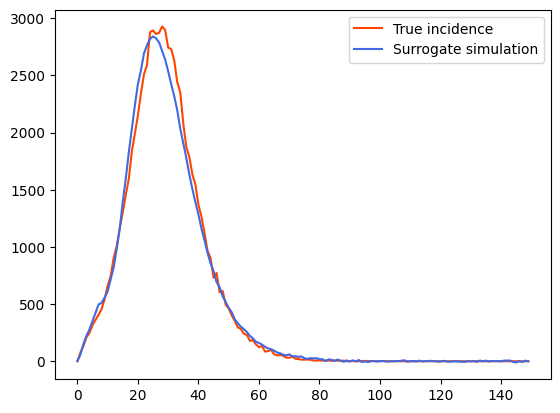

In [5]:
# for alpha, beta in zip(params_dict['alpha_arr'], params_dict['beta_arr']):
#     plt.plot(ae_model.simulate(alpha, beta, gamma, delta, init_inf_frac),
#              color='RoyalBlue', alpha=0.1)
    
plt.plot(observed_incidence, color='OrangeRed', label='True incidence') 
plt.plot(simulation_incidence, color='RoyalBlue', label='Surrogate simulation')
plt.legend()


/var/folders/z9/3mmkvbxj1g5gk4qrms1dj77h0000gn/T/ipykernel_75756/1945119042.py:126: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.savefig('../figures/ae_ba_network_retrospective_clibration.pdf',


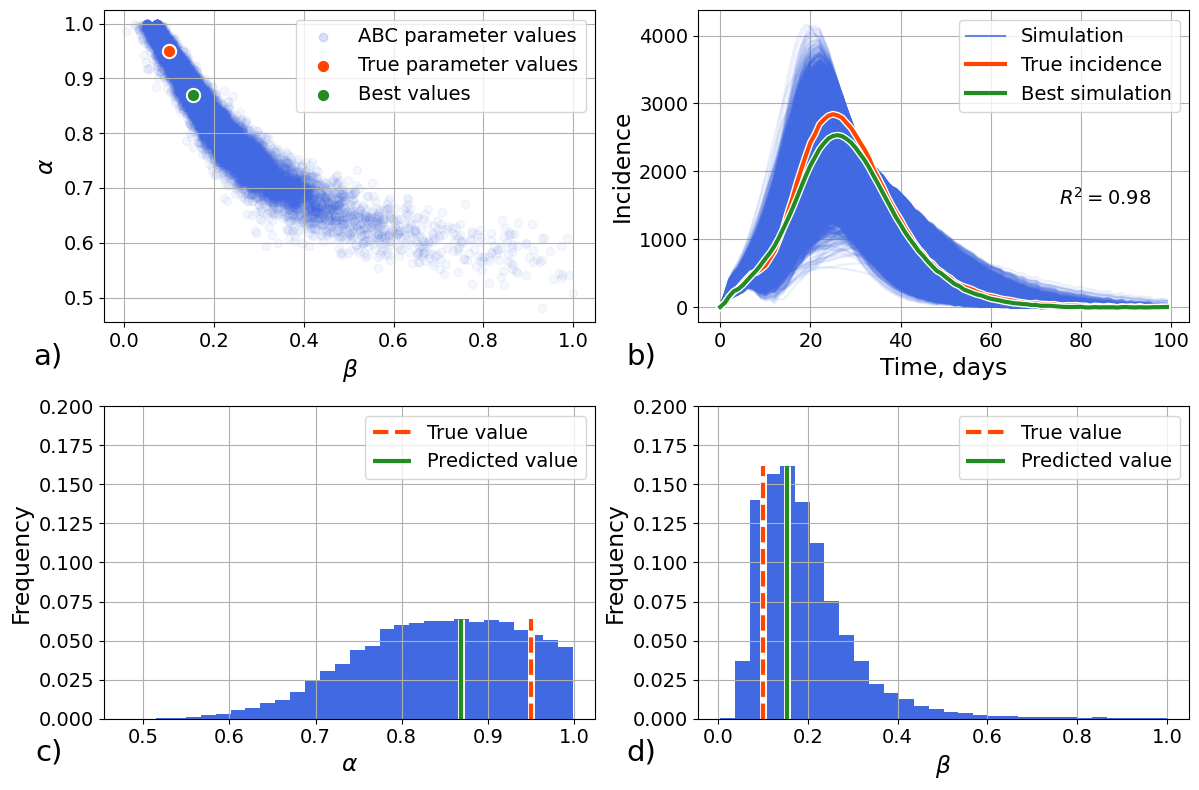

In [24]:
def draw_bar_param(ax, params_dict, true_params_dict, 
                   param_name: str, fontsize=14):
    param_arr = params_dict[param_name + '_arr']
    mode_value = mode_for_floats(param_arr)
    counts, bins, patches = ax.hist(param_arr, color='RoyalBlue', alpha=1, 
                                    bins=30, density=False)
    probabilities = counts / counts.sum()
    ax.clear()

    ax.bar(bins[:-1], probabilities, width=np.diff(bins), color='RoyalBlue', alpha=1, align='edge')
    # ax.hist(param_arr, color='RoyalBlue', alpha=0.2, bins=30, density=True)
    ax.vlines(true_params_dict[param_name], ymin=0, ymax=max(probabilities),
                color='White', lw=5)
    ax.vlines(true_params_dict[param_name], ymin=0, ymax=max(probabilities),
              color='OrangeRed', linestyles='dashed', label='True value', lw=3)
    ax.vlines(mode_value, ymin=0, ymax=max(probabilities), color='White', 
            linestyles='solid', lw=5)
    ax.vlines(mode_value, ymin=0, ymax=max(probabilities), color='ForestGreen', 
              linestyles='solid', label='Predicted value', lw=3)
    ax.set_xlabel(r'$\{}$'.format(param_name), fontsize=1.2*fontsize)
    ax.set_ylabel('Frequency', fontsize=1.2*fontsize)
    ax.set_ylim([0, 0.2])
    ax.tick_params(axis='both', which='major', labelsize=fontsize)
    ax.grid()
    ax.legend(fontsize=fontsize)


def draw_scatter(ax, params_dict, true_params_dict, fontsize=14):
    ax.scatter(params_dict['beta_arr'], params_dict['alpha_arr'], 
               color='RoyalBlue', alpha=0.05)
    ax.scatter(params_dict['beta_arr'][-1], params_dict['alpha_arr'][-1], 
               color='RoyalBlue', alpha=0.2, label='ABC parameter values')
    ax.scatter(true_params_dict['beta'], true_params_dict['alpha'], 
               color='White', s=100)    
    ax.scatter(true_params_dict['beta'], true_params_dict['alpha'], 
               color='OrangeRed', label='True parameter values', s=50)
    best_alpha = mode_for_floats(params_dict['alpha_arr'])
    best_beta = mode_for_floats(params_dict['beta_arr'])

    ax.scatter(best_beta, best_alpha, 
               color='White',
               s=100)
    ax.scatter(best_beta, best_alpha, 
               color='ForestGreen', label='Best values',
               s=50)
    ax.set_xlabel(r'$\beta$', fontsize=1.2*fontsize)
    ax.set_ylabel(r'$\alpha$', fontsize=1.2*fontsize)
    ax.tick_params(axis='both', which='major', labelsize=fontsize)
    ax.legend(fontsize=fontsize)
    ax.grid()
    # ax.set_title('Scatter Plot')

def mode_for_floats(arr, bins=30):
    counts, bin_edges = np.histogram(arr, bins=bins)
    max_bin_index = np.argmax(counts)
    mode_val = (bin_edges[max_bin_index] + bin_edges[max_bin_index + 1]) / 2
    return mode_val

def draw_lines(ax, params_dict, true_params_dict, 
               model=AESurrogateModel(10**5), cut = 100, fontsize=14):
    for alpha, beta in zip(params_dict['alpha_arr'], params_dict['beta_arr']):
        ax.plot(model.simulate(alpha, beta)[:cut], color='RoyalBlue', alpha=0.1)
    ax.plot(model.simulate(alpha, beta)[:cut], color='RoyalBlue', alpha=0.8, label='Simulation')
    
    true_incidence = model.simulate(true_params_dict['alpha'], true_params_dict['beta'])[:cut]
    ax.plot(true_incidence,
        color='White', lw=5)
    ax.plot(true_incidence,
            color='OrangeRed', lw=3, label='True incidence')
    
    best_alpha = mode_for_floats(params_dict['alpha_arr'])
    best_beta = mode_for_floats(params_dict['beta_arr'])

    best_simulation = model.simulate(best_alpha, best_beta)[:cut]

    ax.plot(best_simulation,
            color='White', lw=5)
    ax.plot(best_simulation,
            color='ForestGreen', lw=3, label='Best simulation')
    
    ax.text(75, 1500, r'$R^2={}$'.format(round(r2_score(best_simulation, true_incidence), 2)), fontsize=fontsize, color='k')
    
    ax.set_xlabel('Time, days', fontsize=1.2*fontsize)
    ax.set_ylabel('Incidence', fontsize=1.2*fontsize)
    ax.tick_params(axis='both', which='major', labelsize=fontsize)
    ax.grid()
    ax.legend(fontsize=fontsize)

def create_plots_grid(params_dict, true_params_dict, n_rows=2, n_cols=2, 
                      plot_funcs = [draw_scatter, draw_lines,  
                                    draw_bar_param,  draw_bar_param], fontsize=14):
    alphabet = 'abcdefghijklmnopqrstuvwxyz'
    labels = [alphabet[index] + ')' for index in range(len(alphabet))]
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 4*n_rows))
    if n_rows == 1 and n_cols == 1:
        axes = np.array([[axes]])
    elif n_rows == 1:
        axes = axes[np.newaxis, :]
    elif n_cols == 1:
        axes = axes[:, np.newaxis]

    total_cells = n_rows * n_cols

    for idx in range(total_cells):
        row = idx // n_cols
        col = idx % n_cols
        ax = axes[row, col]
        plot_func = plot_funcs[idx % len(plot_funcs)]
        if idx == 2:
            plot_func(ax, params_dict, true_params_dict, param_name='alpha')
        elif idx == 3:
            plot_func(ax, params_dict, true_params_dict, param_name='beta')
        else:
            plot_func(ax, params_dict, true_params_dict)

        ax.annotate(labels[idx], xy=(0, 0), xycoords='axes fraction',
                            xytext=(-30, -30), textcoords='offset points',
                            fontsize=1.5*fontsize, ha='right', va='baseline')
    plt.tight_layout()
    return fig

true_alpha = 0.95
true_beta = 0.1
# Пример использования:
fig = create_plots_grid(params_dict, true_params_dict={'alpha': true_alpha, 'beta': true_beta})
fig.savefig('../figures/ae_ba_network_retrospective_clibration.pdf', 
            bbox_inches='tight')
fig.savefig('../figures/ae_ba_network_retrospective_clibration.png', 
            dpi = 600, bbox_inches='tight')

In [4]:
forecaster_onset = SEIRForecaster(initial_params=initial_params)
forecaster_peak = SEIRForecaster(initial_params=initial_params)
forecaster_end = SEIRForecaster(initial_params=initial_params)

params_dict_onset = forecaster_onset.calibrate(ae_model, observed_incidence[:10])

Initializing SMC sampler...
Sampling 4 chains in 4 jobs


/Users/andrey/hybrid_surrogate/.env/lib/python3.12/site-packages/rich/live.py:256: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

(array([0]),)
    

/Users/andrey/hybrid_surrogate/.env/lib/python3.12/site-packages/rich/live.py:256: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/Users/andrey/hybrid_surrogate/.env/lib/python3.12/site-packages/arviz/data/base.py:272: UserWarning: More chains (4) than draws (1). Passed array should have shape (chains, draws, *shape)
  warnings.warn(
